# Tutorial for data reduction
# Sample to detector distance of 900 mm - SAXS
We will go through this code together and generate the final scattering curve in absolute units

Firstly we need to install pyFAI as it is not available in the JupyterHub. - https://www.silx.org/doc/pyFAI/dev/index.html
PyFAI is a python libary for azimuthal integration of X-ray/neutron/electron scattering data acquired with area detectors.

The most important packages are: fabio, silx, PyFAI

To run each cell, you press Ctrl + Enter (windows)

- Show shortcuts for other OS

In [1]:
!pip install PyFAI

  Using cached pyfai-2024.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached fabio-2024.4.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (16 kB)
  Using cached silx-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached hdf5plugin-4.4.0-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.9 kB)
Using cached pyfai-2024.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.0 MB)
Using cached silx-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
Using cached fabio-2024.4.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)
Using cached hdf5plugin-4.4.0-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (41.8 MB)


## Import needed packages

In [2]:
import fabio
import pyFAI
import matplotlib.pyplot as plt    # Load matplotlib
import numpy as np
import os

## Load the detector files

In [3]:
# all edf data is colleced in a folder with the same detector distance
folder_name = 'data_900mm'

# now we load all the files in that folder
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(folder_name):
    for file in f:
        if '.edf' in file:
            files.append(os.path.join(file))
print(files)

['Sil_particles_0_00018.edf', 'Sil_particles_0_00026.edf', 'Sil_particles_0_00010.edf', 'Sil_particles_0_00022.edf', 'Sil_particles_0_00003.edf', 'Sil_particles_0_00019.edf', 'Sil_particles_0_00013.edf', 'Sil_particles_0_00004.edf', 'Sil_particles_0_00002.edf', 'Sil_particles_0_00020.edf', 'Sil_particles_0_00006.edf', 'Sil_particles_0_00007.edf', 'Sil_particles_0_00005.edf', 'Sil_particles_0_00016.edf', 'Sil_particles_0_00011.edf', 'Sil_particles_0_00014.edf', 'Sil_particles_0_00021.edf', 'Sil_particles_0_00015.edf', 'Sil_particles_0_00000.edf', 'Sil_particles_0_00025.edf', 'Sil_particles_0_00008.edf', 'Sil_particles_0_00023.edf', 'Sil_particles_0_00024.edf', 'Sil_particles_0_00001.edf', 'Sil_particles_0_00009.edf', 'Sil_particles_0_00012.edf']


## Print the files order, so we know how they appear in the system

In [4]:
# %% LIST NAMES
for ii in range(len(files)):
    im1 = fabio.open(folder_name + '/' + files[ii])
    print(ii, '|', files[ii],  '|',  im1.header['Comment'])



0 | Sil_particles_0_00018.edf | EC -
1 | Sil_particles_0_00026.edf | GC -
2 | Sil_particles_0_00010.edf | SilC_0p1 -
3 | Sil_particles_0_00022.edf | CTAB50_NaSal15 -
4 | Sil_particles_0_00003.edf | SilA_1 -
5 | Sil_particles_0_00019.edf | Plu_5 -
6 | Sil_particles_0_00013.edf | SilB_SilC -
7 | Sil_particles_0_00004.edf | SilB_0p1 -
8 | Sil_particles_0_00002.edf | SilA_0p1 -
9 | Sil_particles_0_00020.edf | Plu_10 -
10 | Sil_particles_0_00006.edf | SilB_5 -
11 | Sil_particles_0_00007.edf | SilB_10 -
12 | Sil_particles_0_00005.edf | SilB_1 -
13 | Sil_particles_0_00016.edf | SilA_SilB_SilC_10 -
14 | Sil_particles_0_00011.edf | SilC_1 -
15 | Sil_particles_0_00014.edf | SilA_SilC -
16 | Sil_particles_0_00021.edf | CTAB50 -
17 | Sil_particles_0_00015.edf | SilA_SilB_SilC -
18 | Sil_particles_0_00000.edf | Empty -
19 | Sil_particles_0_00025.edf | H2O -
20 | Sil_particles_0_00008.edf | SilB_20 -
21 | Sil_particles_0_00023.edf | SilB_1_1p5mm -
22 | Sil_particles_0_00024.edf | SilB_1_2mm -
23 | S

# Corrections in the 2D data

## Determine the X-ray flux at that detector distance

Note that we use fabio, which is a package focused on edf and Nexus format files, dedicated to SAS. This package is installed together with PyFAI.

When read into the variable im_DB, the data will be allocated to the variable im_DB.data and the info in the header in im_DB.header.

Let's first have a look at the detector data, plotted in a linear scale. Note the 1e6 factor multiplying the data.

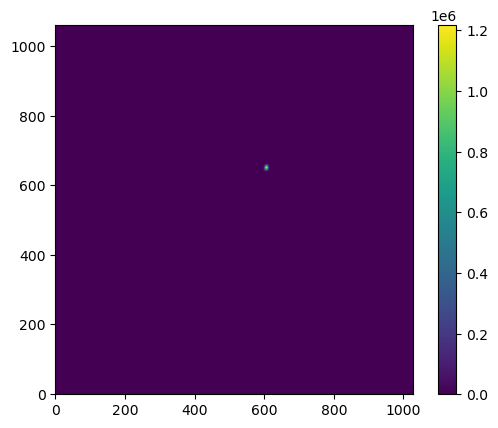

In [19]:
# DETERMINE THE FLUX
# name of direct beam (DB) file: called empty
file_DB = 18

# open the direct beam, Empty file
im_DB = fabio.open(folder_name + '/' + files[file_DB])


# visualize the detector data
plt.imshow(im_DB.data, origin='lower', aspect='equal')             # Display as an image
plt.colorbar()

You can play with the color limits to have a feeling for the data

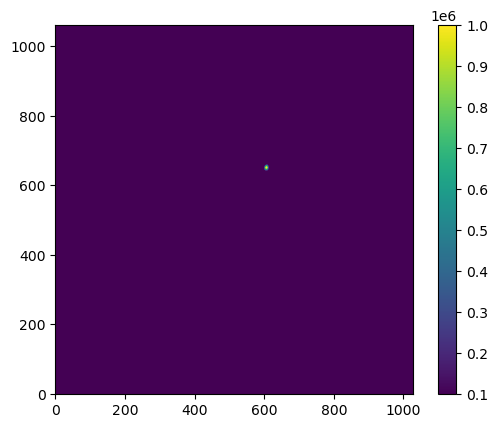

In [6]:
color_limit = [1e5, 1e6]
# visualize the detector data
plt.imshow(im_DB.data, origin='lower', aspect='equal', clim = color_limit)             # Display as an image
plt.colorbar()

A typical way to show the data is to make a log10 scale, while you can see the color axis with the expected order of magnitude, there are problems, since log10(0) is undefined, and is shown as white.

/tmp/ipykernel_126/1205180559.py:2: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(im_DB.data), origin='lower', aspect='equal')             # Display as an image


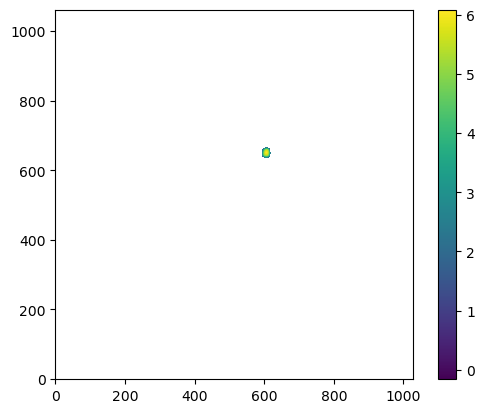

In [7]:
# visualize the detector data
plt.imshow(np.log10(im_DB.data), origin='lower', aspect='equal')             # Display as an image
plt.colorbar()

A better way to visualize the data is then using the ArcSinh[z] gives the inverse hyperbolic sine of the value z. However, not that the axis is not the number of intensity decades, which is given by Log10.

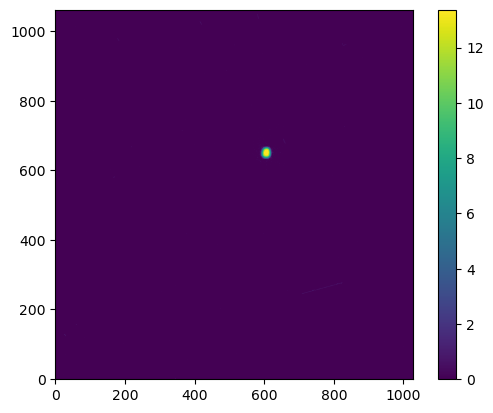

In [8]:
color_limit = [0, np.max(np.arcsinh(im_DB.data))/1.1]
# visualize the detector data
plt.imshow(np.arcsinh(im_DB.data), origin='lower', aspect='equal', clim = color_limit)             # Display as an image
plt.colorbar()

 Now we can have a look at the header or the so-called metadata that the detector saves with the measurement.
 This one is related to the direct beam.

In [9]:
print(im_DB.header)

{
  "EDF_DataBlockID": "0.Image.Psd",
  "EDF_BinarySize": "4366944",
  "EDF_HeaderSize": "3584",
  "ByteOrder": "LowByteFirst",
  "DataType": "FloatValue",
  "Dim_1": "1028",
  "Dim_2": "1062",
  "Image": "0",
  "HeaderID": "EH:000000:000000:000000",
  "Size": "4366944",
  "Center_1": "607.1458",
  "Center_2": "649.9503",
  "Comment": "Empty -",
  "DDummy": "0.6",
  "Date": "2024-03-20T11:49:33",
  "Delta": "0",
  "Dummy": "-1.5",
  "ExposureTime": "10",
  "Gamma": "0",
  "Intensity1": "1.20634e-08",
  "PSize_1": "7.5e-05",
  "PSize_2": "7.5e-05",
  "SampleDistance": "0.900002",
  "SampleEnvKind": "saxs",
  "SampleEnvPN": "Capillaries",
  "SampleEnvSN": "517",
  "Thickness": "0",
  "User": "Viviane Lutz",
  "WaveLength": "1.541889e-10",
  "Wavelength": "1.54189e-10",
  "XLx": "0",
  "XLx_dial": "0",
  "XLz": "0",
  "XLz_dial": "0",
  "anaB": "-0.0382156",
  "anaB_dial": "3.87582e-05",
  "anaPark": "-174.232",
  "anaPark_dial": "174.277",
  "anaXi": "0.343562",
  "anaXi_dial": "0.343562

## Estimate the flux

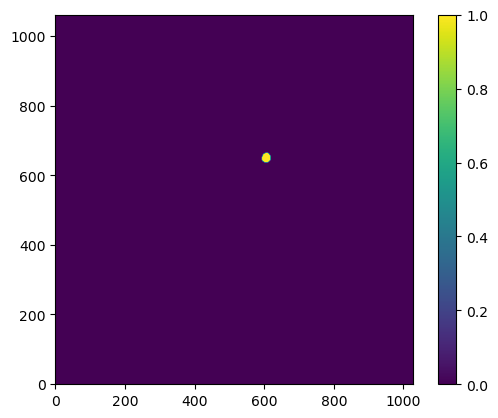

In [15]:
# for flux normalization
counts = im1.data
# We create a Boolean mask (0 and 1) around the direct beam

# find a cutoff value for the intensity
# here I define a cutoff value of the maximum intensity divided by 1e3
cutoff = counts[counts > 0].max()/1000

# make values smaller than cutoff equal to 0 = mask
counts = np.where(counts < cutoff, 0, counts)

# make values larger than cutoff equal to 1 = NOT mask
mask_DB = np.where(counts >= cutoff, 1, counts)

#We plot the mask and compare to the direct beam image
plt.imshow(mask_DB, origin='lower', aspect='equal')             # Display as an image
plt.colorbar()


Now we can extract other values that will be needed for the corrections

In [16]:
# extract relevant information from the file
time_DB = float(im_DB.header['ExposureTime'])
print('Exposure time is ', time_DB, 'seconds')
flux_DB = np.mean(im_DB.data[mask_DB>0])/time_DB
print('Flux is ', flux_DB, 'photons/s')

Exposure time is  10.0 seconds
Flux is  21457.3828125 photons/s


# Define a function for the corrections

In [17]:
# im_S is the detector file that you would like to correct
# thickness is either the actual thickness in cm or you can provide "None" to read it from the header

def plot_correct(im_S, thickness):
    # extract relevant information from the given scattering patter
    time_S = float(im_S.header['ExposureTime'])
    # here we apply the mask defined above to know the intensity of the beam transmitted through the sample
    flux_S = np.mean(im_S.data[mask_DB>0])/time_S
    # if "None" is provided, read the actual thickness
    # I added this as sometimes the thickness is not known precisely
    if thickness == 'None':
        thickness = float(im_S.header['Thickness'])/10 # in cm
    if thickness == 0:
        thickness = 0.1 # in cm
    # for transmission normalization
    # calculate the realtive transmission, regarding the air
    transmission = flux_S/flux_DB
    # correct the 2D signal
    im = im_S.data
    # correct by flux_DB
    ic = np.divide(im, flux_DB)
    # correct by  transmission
    ic = np.divide(im, transmission)
    # correct by exposure time
    ic = np.divide(ic, time_S)
    # correct by sample thickness
    ic = np.divide(ic, thickness)
    # print results
    print('The x-ray flux at the sample is ', flux_DB, 'Photons/s')
    print('The trasmitted flux is ', flux_S, 'Photons/s')
    print('The sample transmission is', transmission)
    print('The sample thickness is', thickness, 'cm')
    return ic


## Load the mask and the PONI

This we create typing in the command line "pyFAI-calib2.exe". We can not run it through Jupyter because of the graphical interface, but we can load them.
We can see the silver behenate AgBE that has typical rings, often used for the sample to detector distance and beam center calibrations.

The x-ray flux at the sample is  21457.3828125 Photons/s
The trasmitted flux is  3345.9294270833334 Photons/s
The sample transmission is 0.15593371551045648
The sample thickness is 0.1 cm


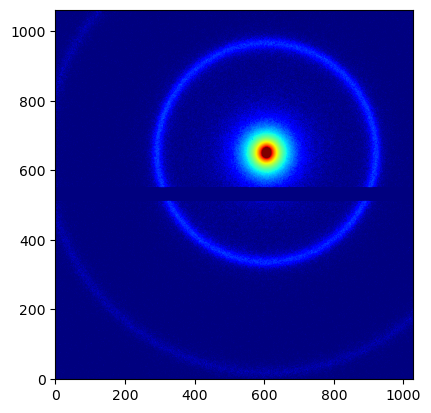

In [20]:
# calibrate the geometry
# order for the calibrant AgBE
file_AgBE = 23
# load the file
im_AgBE = fabio.open(folder_name + '/' + files[file_AgBE])     # Open image file
# provide the expected thickness of the capillary. This might be adjusted
thickness_AgBE = 0.1 # in cm
# apply the corrections from the function above
im_AgBE = plot_correct(im_AgBE, thickness_AgBE)
plt.imshow(np.arcsinh(im_AgBE.data), origin='lower', cmap = 'jet', aspect='equal', clim = [0, np.max(np.arcsinh(im_AgBE.data))/1.5])             # Display as an image




Integrator: 
 Detector Eiger2 1M	 PixelSize= 7.500e-05, 7.500e-05 m	 BottomRight (3)
Wavelength= 1.541000e-10 m
SampleDetDist= 8.935896e-01 m	PONI= 4.869929e-02, 4.565685e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 893.590 mm	Center: x=608.758, y=649.324 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.541Å


Text(0.5, 1.0, 'mask detector module and direct beam')

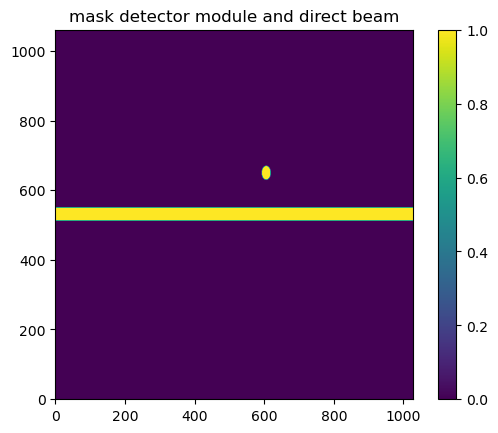

In [21]:
# the poni step must be performed out of JupyterHub because it requires a graphical interface
# load PONI file
poni = "dd_900mm_PONI.poni"
#load poni file
ai = pyFAI.load(poni)
# this is important, as it sets the position of the zero angle
ai.setChiDiscAtZero()

print("\nIntegrator: \n", ai)


# load mask
maskDB = "maskDB_900mm.edf"
maskDB = fabio.open(maskDB)
maskDB = maskDB.data;

plt.imshow(maskDB, origin='lower', aspect='equal')             # Display as an image
plt.colorbar()
plt.title('mask detector module and direct beam')


## Load the empty capillary 

The x-ray flux at the sample is  21457.3828125 Photons/s
The trasmitted flux is  12950.352222222222 Photons/s
The sample transmission is 0.6035382942731484
The sample thickness is 0.1 cm


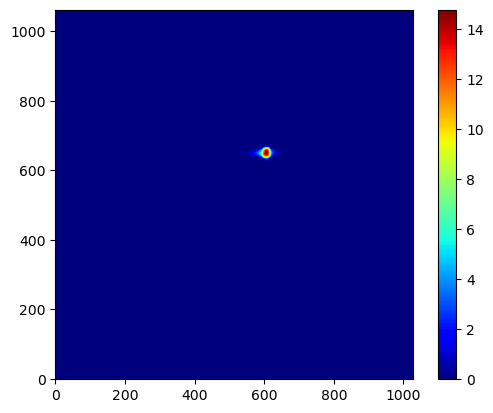

In [22]:
# open the file of interest, in this case the empty capillary
file_EC = 0
# load the file
im_EC = fabio.open(folder_name + '/' + files[file_EC])     # Open image file
# provide the expected thickness of the capillary. This might be adjusted
thickness_EC = 0.1 # in cm
# apply the corrections from the function above
im_EC = plot_correct(im_EC, thickness_EC)
plt.imshow(np.arcsinh(im_EC.data), origin='lower', cmap = 'jet', aspect='equal', clim = [0, np.max(np.arcsinh(im_EC.data))])             # Display as an image
plt.colorbar()

## Mask the capillary wall streak

We masked the detector module gap, the direct beam, and streaks from the capillary walls

Text(0.5, 1.0, 'Mask')

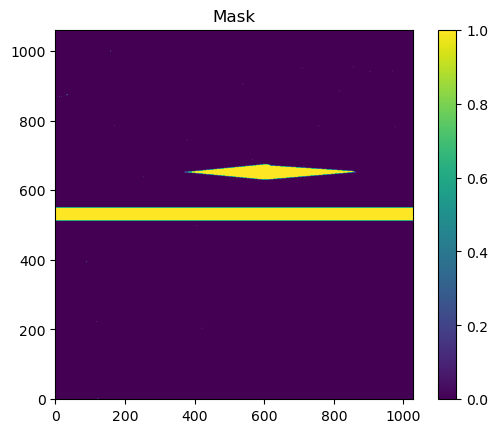

In [23]:
# load second mask
maskH = 'maskH_900mm.edf'
maskH = fabio.open(maskH)
maskH = maskH.data

plt.figure()
plt.imshow(maskH, origin='lower', aspect='equal')             # Display as an image
plt.colorbar()
plt.title('Mask')


## Compare the types of masking, and the influence on the integrated results

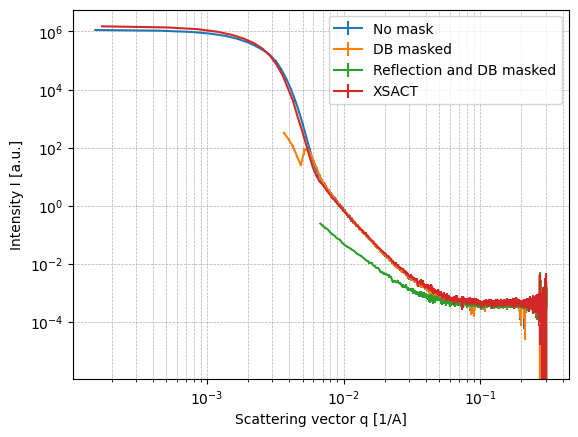

In [24]:
img_array = im_EC

# radial integration without masking
q1, I1, sigma1 = ai.integrate1d(img_array, 1000, unit="q_A^-1", error_model='azimuthal', correctSolidAngle=True)
#show the integrated data
plt.errorbar(q1, I1, sigma1)

# Radial integration masking only the direct beam
q2, I2, sigma2 = ai.integrate1d(img_array, 1000, unit="q_A^-1", mask = maskDB, error_model='azimuthal', correctSolidAngle=True)
#show the integrated data
plt.errorbar(q2, I2, sigma2)

# radial integration masking the direct beam and the reflactions from the capillary walls
q_EC, I_EC, sigma_EC = ai.integrate1d(img_array, 1000, unit="q_A^-1", mask = maskH, error_model='azimuthal',correctSolidAngle=True)
plt.errorbar(q_EC, I_EC, sigma_EC)

# load the integration from XSACT
f_EC = np.loadtxt('Sil_particles_0_00018.dat', skiprows=153)
plt.errorbar(f_EC[:, 0], f_EC[:, 1], f_EC[:, 2])

# settingd for the plot
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Scattering vector q [1/A]')
plt.ylabel('Intensity I [a.u.]')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend(['No mask', 'DB masked', 'Reflection and DB masked', 'XSACT'])


## Focusing on the radial integration function

Additional information can be found here: https://www.silx.org/doc/pyFAI/dev/api/pyFAI.html

In [26]:
# 2D array from the Detector
data = img_array
# number of points in the output pattern
npt = 1000
# output filename in 3 column ascii format: q, I and sigma
filename = 'integrated.dat'
# correct for solid angle of each pixel if True
correctSolidAngle = True
# When the variance is unknown, an error model can be given: “poisson” (variance = I), “azimuthal” (variance = (I-<I>)^2)
error_model =  'azimuthal'
# The lower and upper range of the radial unit. If not provided, range is simply (min, max). Values outside the range are ignored.
radial_range = [] 
# The lower and upper range of the azimuthal angle in degree. If not provided, range is simply (min, max). Values outside the range are ignored.
azimuth_range = [0, 45]
# Array with 0 for valid pixels, all other are masked (static mask)
mask = maskH
#Output units, can be “q_nm^-1”, "q_A^-1", “2th_deg”, “r_mm”.
unit = "q_A^-1"

# let's compare the integrations every 60 degrees
az_start = range(0,360, 60)
az_end = range(60,361, 60)


## Confirm the suitability of the data masking

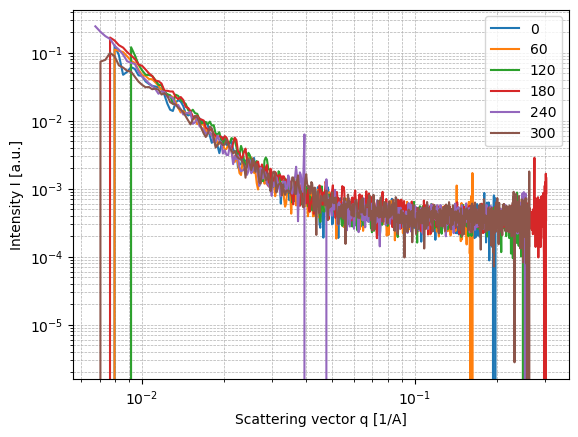

In [27]:
# first using the mask with the horizontal exclusion
for ii in range(len(az_start)):
    azimuth_range = [az_start[ii], az_end[ii]]
    q1, I1, sigma1 = ai.integrate1d(data, npt, unit=unit, error_model=error_model, correctSolidAngle=True, mask = maskH, azimuth_range=azimuth_range)
    #show the integrated data
    plt.loglog(q1, I1)

# settingd for the plot
plt.xlabel('Scattering vector q [1/A]')
plt.ylabel('Intensity I [a.u.]')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend(az_start)

## Compare to the other mask type

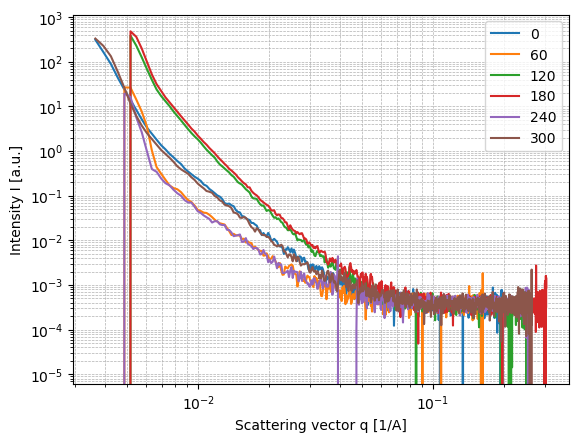

In [28]:
# then without a mask
for ii in range(len(az_start)):
    azimuth_range = [az_start[ii], az_end[ii]]
    q1, I1, sigma1 = ai.integrate1d(data, npt, unit=unit, error_model=error_model, correctSolidAngle=True, azimuth_range=azimuth_range, mask = maskDB)
    #show the integrated data
    plt.loglog(q1, I1)

# settingd for the plot
plt.xlabel('Scattering vector q [1/A]')
plt.ylabel('Intensity I [a.u.]')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend(az_start)

## Showing anisotropy

Here we can actually see alignement

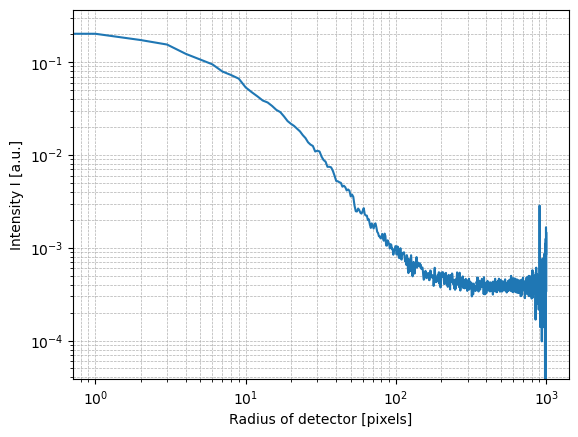

In [29]:
# how to figure our the radial range, when needed
plt.loglog(I_EC)
plt.xlabel('Radius of detector [pixels]')
plt.ylabel('Intensity I [a.u.]')
plt.grid(which='both', linestyle='--', linewidth=0.5)


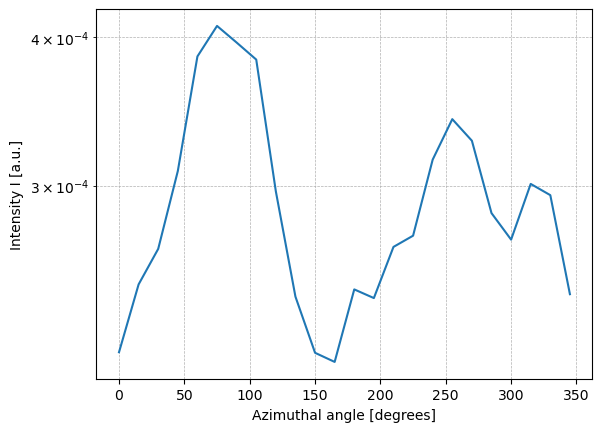

In [30]:
# let's compare the integrations every 10 degrees
az_start = range(0,360, 15)
az_end = range(15,361, 15)

# radial range
radial_range = [10, 100]

# initialize a variable to save the sums
sum_sector = []
# then without a mask
for ii in range(len(az_start)):
    azimuth_range = [az_start[ii], az_end[ii]]
    q1, I1, sigma1 = ai.integrate1d(data, len(radial_range), unit=unit, error_model=error_model, correctSolidAngle=True, azimuth_range=azimuth_range, mask = maskH, radial_range = radial_range)
    sum_sector.append(np.mean(I1))
    
plt.semilogy(az_start, sum_sector)
plt.xlabel('Azimuthal angle [degrees]')
plt.ylabel('Intensity I [a.u.]')
plt.grid(which='both', linestyle='--', linewidth=0.5)
#plt.ylim([1e-4, 1e-1])

(0.0001, 0.1)

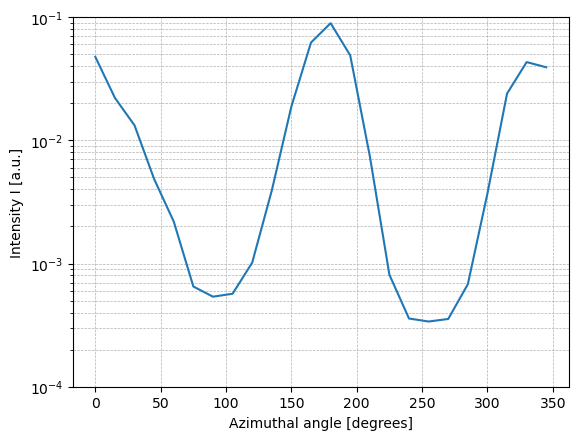

In [31]:
# let's compare the integrations every 10 degrees
az_start = range(0,360, 15)
az_end = range(15,361, 15)

# radial range
radial_range = [300, 1000]

# initialize a variable to save the sums
sum_sector = []
# then without a mask
for ii in range(len(az_start)):
    azimuth_range = [az_start[ii], az_end[ii]]
    q1, I1, sigma1 = ai.integrate1d(data, len(radial_range), unit=unit, error_model=error_model, correctSolidAngle=True, azimuth_range=azimuth_range, mask = maskDB, radial_range = radial_range)
    sum_sector.append(np.mean(I1))
    
plt.semilogy(az_start, sum_sector)
plt.xlabel('Azimuthal angle [degrees]')
plt.ylabel('Intensity I [a.u.]')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.ylim([1e-4, 1e-1])

# Absolute scaling

## Using the GC

Here we compare the known scattering curve from glassy carbon to the measured at ETH, and determine the scaling factor for the absolute calibration correction.

[[1.34583003e-02 3.62171017e+01]
 [1.39593141e-02 3.60594527e+01]
 [1.44769573e-02 3.59115039e+01]
 ...
 [3.33893547e+00 3.66590294e-02]
 [3.34109063e+00 3.88807887e-02]
 [3.34324458e+00 3.54092897e-02]]
The x-ray flux at the sample is  21457.3828125 Photons/s
The trasmitted flux is  8678.565972222223 Photons/s
The sample transmission is 0.40445594171748306
The sample thickness is 0.11599999999999999 cm


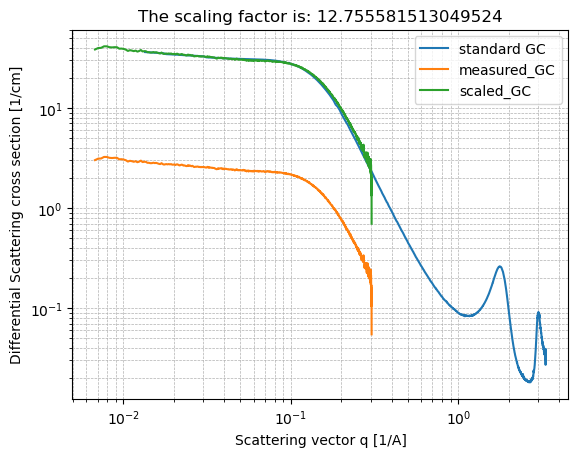

In [32]:
# %% load the GC satndard values
std_GC = np.loadtxt('GC_standard.dat', skiprows=3, delimiter=',')

print(std_GC)
# open the measured GC file 
file_GC = 1

im_GC = fabio.open(folder_name + '/' + files[file_GC])     # Open image file
im_GC = plot_correct(im_GC, 'None')

# name to save
q1, I1 = ai.integrate1d(im_GC, 1000, unit="q_A^-1", mask = maskH)


scaling_factor = np.median(std_GC[:20,1])/np.median(I1[:100])

# Background subtraction
plt.loglog(std_GC[:,0], std_GC[:,1])
plt.loglog(q1, I1)
plt.loglog(q1, I1*scaling_factor)
plt.title('The scaling factor is: ' + str(scaling_factor))
plt.legend(['standard GC', 'measured_GC', 'scaled_GC'])


# settings for the plot
plt.xlabel('Scattering vector q [1/A]')
plt.ylabel('Differential Scattering cross section [1/cm]')
plt.grid(which='both', linestyle='--', linewidth=0.5)



## Radially integrate all samples using the scaling factor from glassy carbon

____________________________________________________________________
Integrating sample    EC -
The x-ray flux at the sample is  21457.3828125 Photons/s
The trasmitted flux is  12950.352222222222 Photons/s
The sample transmission is 0.6035382942731484
The sample thickness is 0.1 cm
____________________________________________________________________
Integrating sample    GC -
The x-ray flux at the sample is  21457.3828125 Photons/s
The trasmitted flux is  8678.565972222223 Photons/s
The sample transmission is 0.40445594171748306
The sample thickness is 0.11599999999999999 cm
____________________________________________________________________
Integrating sample    SilC_0p1 -
The x-ray flux at the sample is  21457.3828125 Photons/s
The trasmitted flux is  5163.767222222222 Photons/s
The sample transmission is 0.24065223924765275
The sample thickness is 0.1 cm
____________________________________________________________________
Integrating sample    CTAB50_NaSal15 -
The x-ray flux at the

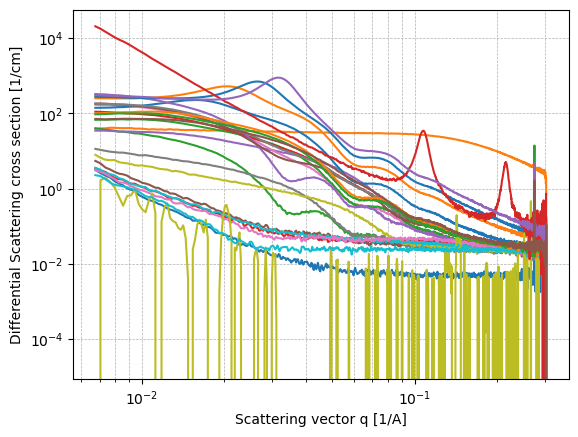

In [33]:
## Radially integrate all samples
save_path = 'integrated_GC_900mm'

for ii in range(len(files)):
    im_s = fabio.open(folder_name + '/' + files[ii])     # Open image file
    print('____________________________________________________________________')
    name = im_s.header['Comment']
    print('Integrating sample   ', name)
    im_s = plot_correct(im_s, 'None') # thickness in cm
  
    # name to save
    save_as = save_path + '/' + name[:-2] + '.dat'
    q, I, sigma = ai.integrate1d(im_s, 1000, unit="q_A^-1", mask = maskH, error_model='azimuthal',correctSolidAngle=True)
    plt.loglog(q, I*scaling_factor)
    save_data = np.transpose(np.vstack([q, I*scaling_factor, sigma]))
    np.savetxt(save_as , save_data)

# settings for the plot
plt.xlabel('Scattering vector q [1/A]')
plt.ylabel('Differential Scattering cross section [1/cm]')
plt.grid(which='both', linestyle='--', linewidth=0.5)

## Using water

We use water as an example, because we known the Differential Scattering cross section = dΣ/dΩ: 1.632 · 10-2 cm-1

Should we first subtract the background or first scale to absolute units?

The x-ray flux at the sample is  21457.3828125 Photons/s
The trasmitted flux is  6117.485 Photons/s
The sample transmission is 0.28509930840383096
The sample thickness is 0.1 cm


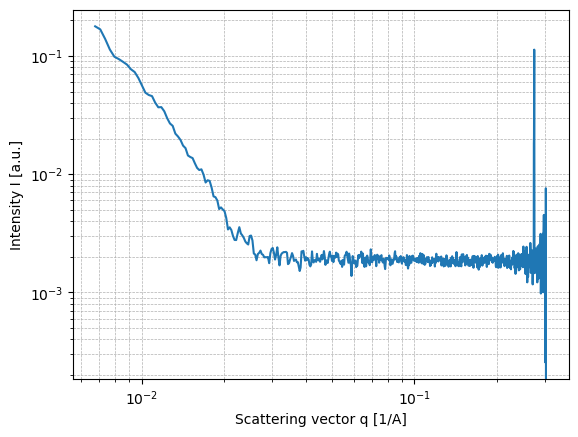

In [34]:
# %% load water

# open the file of interest, in this case the empty capillary
file_H2O = 19

im_H2O = fabio.open(folder_name + '/' + files[file_H2O])     # Open image file
im_H2O = plot_correct(im_H2O, 0.1) # thickness in cm

# name to save
q_H2O, I_H2O, sigma_H2O = ai.integrate1d(im_H2O, 1000, unit="q_A^-1", mask = maskH, error_model='azimuthal',correctSolidAngle=True)

#show the integrated data
plt.loglog(q_H2O, I_H2O)
# settings for the plot
plt.xlabel('Scattering vector q [1/A]')
plt.ylabel('Intensity I [a.u.]')
plt.grid(which='both', linestyle='--', linewidth=0.5)



##  Background subtraction

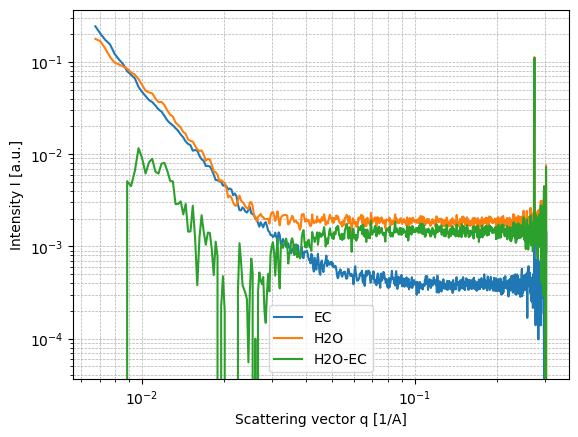

In [35]:
# First subtract
plt.loglog(q_EC, I_EC)
plt.loglog(q_H2O, I_H2O)
I_H2O_c = I_H2O-I_EC
plt.loglog(q_H2O, I_H2O_c)

# settings for the plot
plt.xlabel('Scattering vector q [1/A]')
plt.ylabel('Intensity I [a.u.]')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend(['EC', 'H2O', 'H2O-EC'])


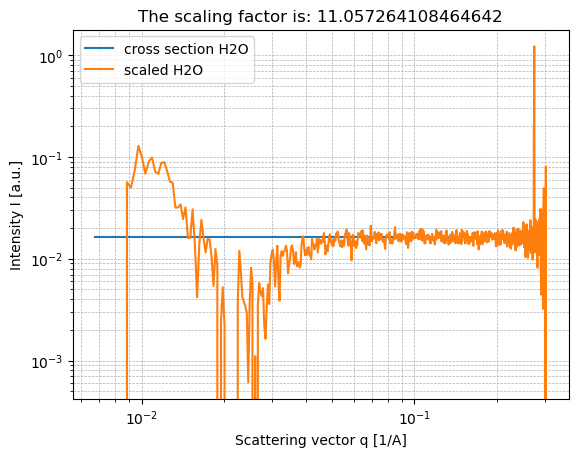

In [36]:
scaling_factor_H2O = 1.62e-2/np.mean(I_H2O_c[300:600])

plt.loglog(q_H2O, np.ones(len(I_H2O_c))*1.62e-2)
plt.loglog(q_H2O, I_H2O_c*scaling_factor_H2O)
plt.title('The scaling factor is: ' + str(scaling_factor_H2O))

# settings for the plot
plt.xlabel('Scattering vector q [1/A]')
plt.ylabel('Intensity I [a.u.]')
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend(['cross section H2O', 'scaled H2O'])

## Radially integrate all samples using the scaling factor from water

____________________________________________________________________
Integrating sample    EC -
The x-ray flux at the sample is  21457.3828125 Photons/s
The trasmitted flux is  12950.352222222222 Photons/s
The sample transmission is 0.6035382942731484
The sample thickness is 0.1 cm
____________________________________________________________________
Integrating sample    GC -
The x-ray flux at the sample is  21457.3828125 Photons/s
The trasmitted flux is  8678.565972222223 Photons/s
The sample transmission is 0.40445594171748306
The sample thickness is 0.11599999999999999 cm
____________________________________________________________________
Integrating sample    SilC_0p1 -
The x-ray flux at the sample is  21457.3828125 Photons/s
The trasmitted flux is  5163.767222222222 Photons/s
The sample transmission is 0.24065223924765275
The sample thickness is 0.1 cm
____________________________________________________________________
Integrating sample    CTAB50_NaSal15 -
The x-ray flux at the

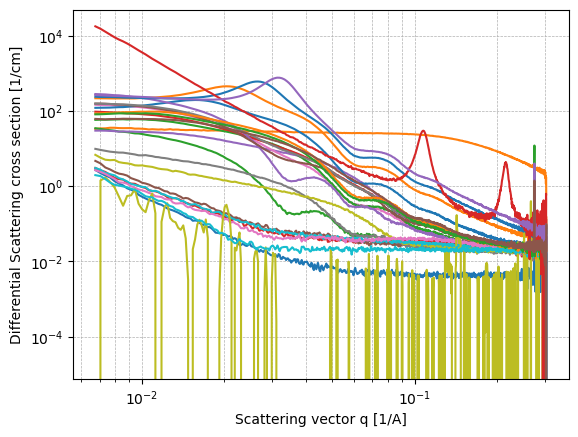

In [37]:
## Radially integrate all samples
save_path = 'integrated_H2O_900mm'

for ii in range(len(files)):
    im_s = fabio.open(folder_name + '/' + files[ii])     # Open image file
    print('____________________________________________________________________')
    name = im_s.header['Comment']
    print('Integrating sample   ', name)
    im_s = plot_correct(im_s, 'None') # thickness in cm
  
    # name to save
    save_as = save_path + '/' + name[:-2] + '.dat'
    q, I, sigma = ai.integrate1d(im_s, 1000, unit="q_A^-1", mask = maskH, error_model='azimuthal',correctSolidAngle=True)
    plt.loglog(q, I*scaling_factor_H2O)
    save_data = np.transpose(np.vstack([q, I*scaling_factor_H2O, sigma]))
    np.savetxt(save_as , save_data)

# settings for the plot
plt.xlabel('Scattering vector q [1/A]')
plt.ylabel('Differential Scattering cross section [1/cm]')
plt.grid(which='both', linestyle='--', linewidth=0.5)